In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
import numpy as np

import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_csv('big_mart_train.csv')

In [3]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

___

There are quite a few missing values for item weight.  The solution will be to create a table grouped by item_identifier to reference for missing values. 

In [5]:
lookup_weight_values = data.iloc[:,0:2].groupby(by='Item_Identifier').max()

In [6]:
imputed_data = data

In [7]:
imputed_data = imputed_data.merge(lookup_weight_values,on='Item_Identifier')

In [8]:
imputed_data = imputed_data.drop(columns=['Item_Weight_x'])

In [9]:
imputed_data.rename(columns={'Item_Weight_y': 'Item_Weight'}, inplace=True)

In [10]:
# 4 missing values
imputed_data.isnull().sum()

Item_Identifier                 0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
Item_Weight                     4
dtype: int64

In [11]:
#only rows with missing values
imputed_data[imputed_data['Item_Weight'].isnull()]

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight
4125,FDN52,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564,NaN
6440,FDK57,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280,NaN
8278,FDE52,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046,NaN
8463,FDQ60,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098,NaN


In [12]:
# drop rows with missing values (only 4 in this case)
imputed_data = imputed_data.dropna()

___

Outlet_Size will need to be imputed in the future.  Dropping the column to reduce noise for now.
#FIXME

In [13]:
imputed_data = imputed_data.drop('Outlet_Size', axis='columns')

In [14]:
imputed_data.head()

,Item_Identifier,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Weight
0,FDA15,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Tier 1,Supermarket Type1,3735.1380,9.3
2,FDA15,Low Fat,0.016019,Dairy,248.5092,OUT035,2004,Tier 2,Supermarket Type1,6474.2392,9.3
3,FDA15,Low Fat,0.016088,Dairy,249.6092,OUT018,2009,Tier 3,Supermarket Type2,5976.2208,9.3
5,FDA15,Low Fat,0.016009,Dairy,250.6092,OUT013,1987,Tier 3,Supermarket Type1,6474.2392,9.3
6,FDA15,Low Fat,0.015945,Dairy,249.5092,OUT027,1985,Tier 3,Supermarket Type3,6474.2392,9.3


___

* Drop Item_Identifier
* Encode dummy variables
* Split lable from data

In [15]:
#item identifier isn't useful in this context
imputed_data = imputed_data.drop('Item_Identifier', axis='columns')

In [16]:
#encode non_numeric types to their own column with binary values
data_encoded = pd.get_dummies(imputed_data)

In [17]:
data_label = data_encoded.pop('Item_Outlet_Sales')

In [18]:
#add the label to the end of the DF
data_encoded['Item_Outlet_Sales'] = data_label

___

### Prepare to model

* Create x & y 
* Split data into train / test

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X, y = data_encoded.iloc[:,:-1],data_encoded.iloc[:,-1]

In [21]:
seed = 7
test_size = 0.33
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

___

### XGBoost

In [22]:
import xgboost as xgb

In [23]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [24]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear')

In [25]:
xgb_model = xg_reg.fit(x_train,y_train)
y_xgb = xgb_model.predict(x_test)

___

### SVM
[docs](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py)

In [26]:
from sklearn.svm import SVR

In [27]:
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
rbf_model = svr_rbf.fit(x_train, y_train)
y_rbf = rbf_model.predict(x_test)

In [28]:
svr_lin = SVR(kernel='linear', C=1e3)
linear_model = svr_lin.fit(x_train, y_train)
y_lin = linear_model.predict(x_test)

In [29]:
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
poly_model = svr_poly.fit(x_train, y_train)
y_poly = poly_model.predict(x_test)

/Users/justinbarker/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


---

### Evaluate Models

1. y_xgb
2. y_rbf
3. y_lin
4. y_poly

In [30]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from numpy import sqrt

___

XGBoost

In [31]:
r2_score(y_test, y_xgb)

0.5562056861177511

In [32]:
sqrt(mean_squared_error(y_test, y_xgb))

1143.5297642579853

___

RBF

[docs](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)

In [33]:
r2_score(y_test, y_rbf)

0.38101041224674004

In [34]:
sqrt(mean_squared_error(y_test, y_rbf))

1350.511473453775

___

Linear

In [35]:
r2_score(y_test, y_lin)

0.4217786726474184

In [36]:
sqrt(mean_squared_error(y_test, y_lin))

1305.2799273987478

___

Polyonmial

In [37]:
r2_score(y_test, y_poly)

-3380667.041956052

In [38]:
sqrt(mean_squared_error(y_test, y_poly))

3156151.7076880783

___
Plot Results

In [39]:
import matplotlib.pyplot as plt

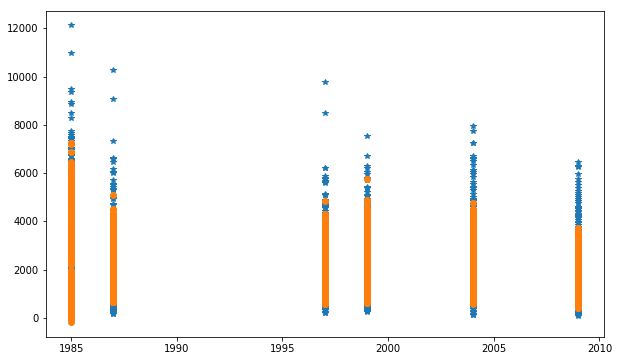

In [40]:
plt.figure(figsize=(10,6))
plt.plot(x_test['Outlet_Establishment_Year'], y_test, '*',
        x_test['Outlet_Establishment_Year'], y_xgb, 'o')

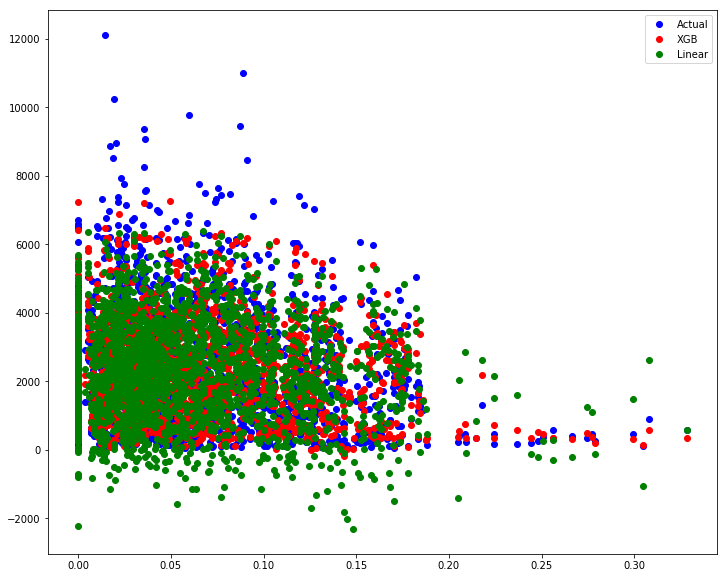

In [41]:
plt.figure(figsize=(12,10))
plt.plot(x_test['Item_Visibility'], y_test, 'o', color='b', label='Actual')
plt.plot(x_test['Item_Visibility'], y_xgb, 'o', color='r', label='XGB')
plt.plot(x_test['Item_Visibility'], y_lin, 'o', color='g', label='Linear')
plt.legend()

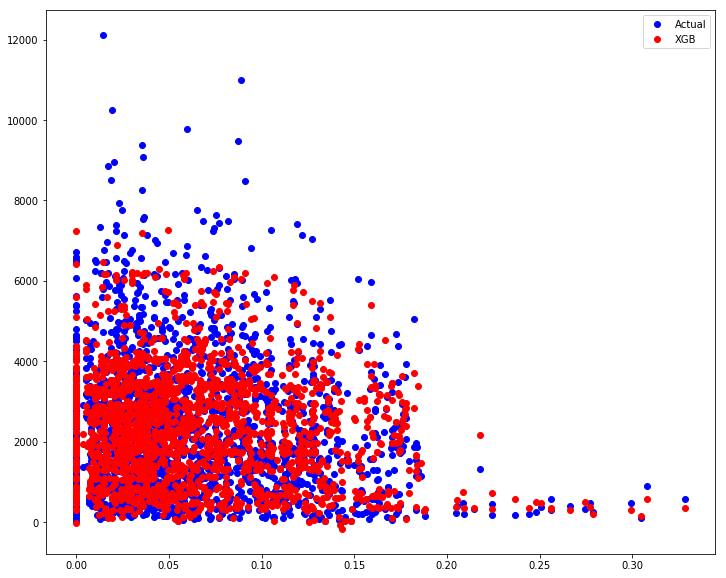

In [42]:
plt.figure(figsize=(12,10))
plt.plot(x_test['Item_Visibility'], y_test, 'o', color='b', label='Actual')
plt.plot(x_test['Item_Visibility'], y_xgb, 'o', color='r', label='XGB')
plt.legend()